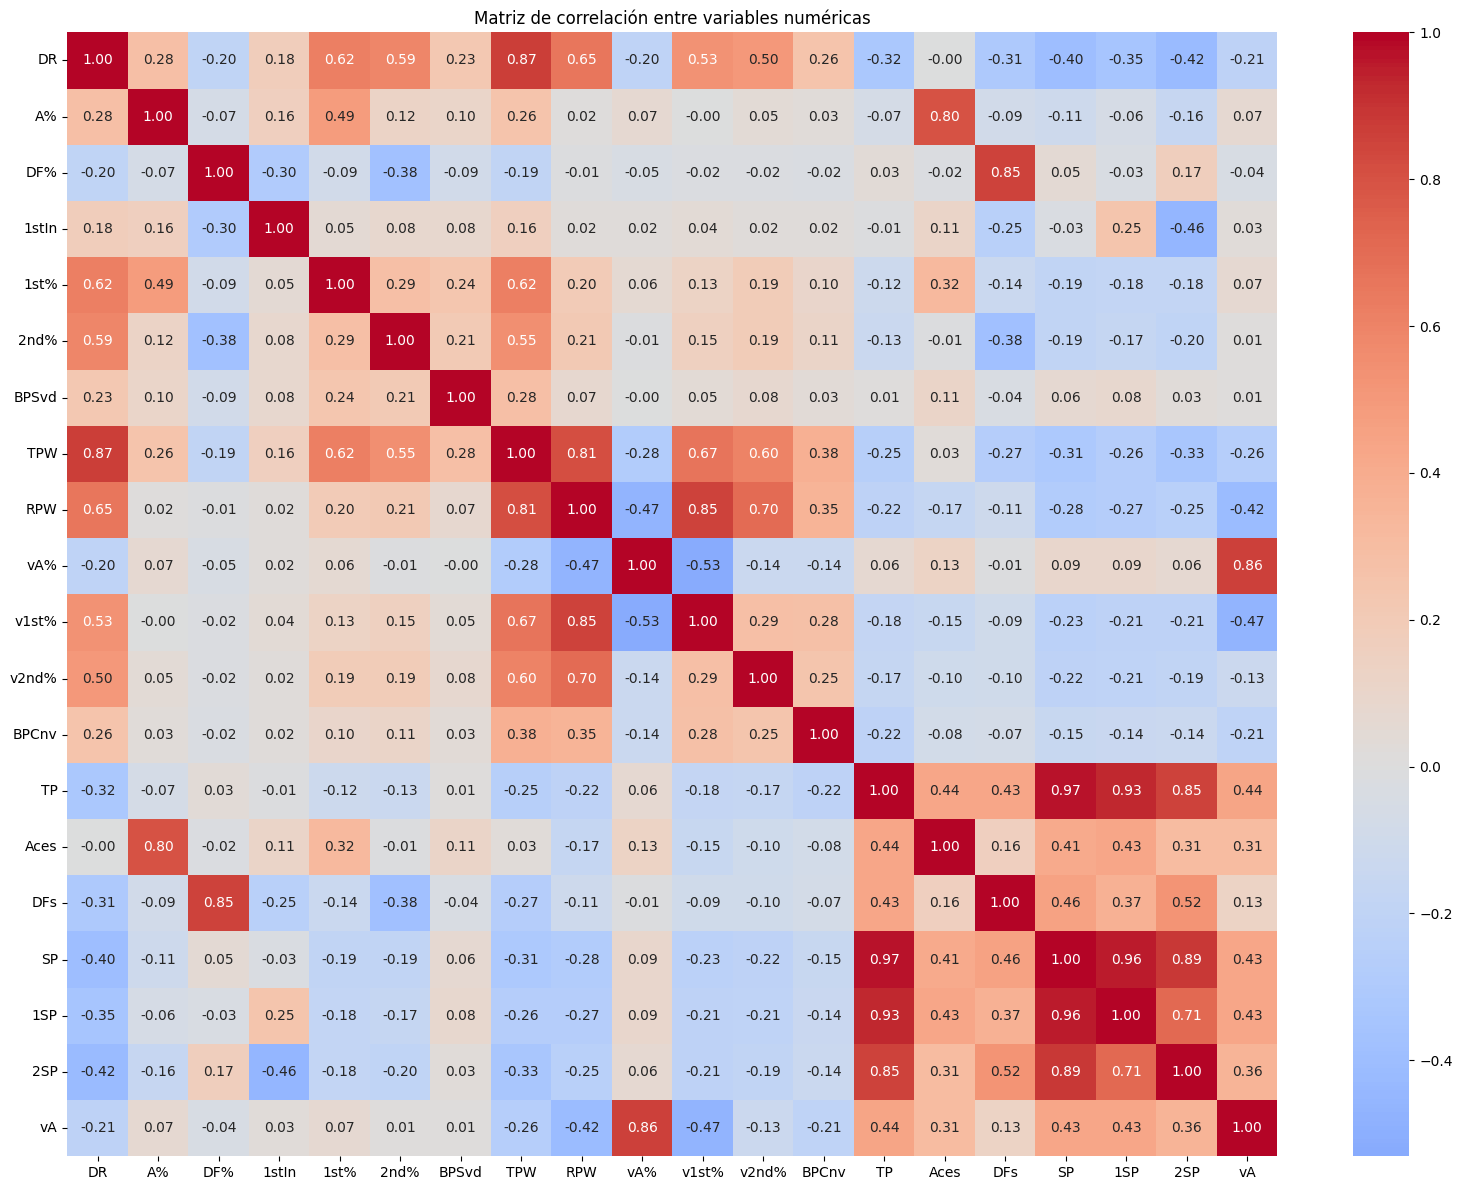

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- BLOQUE 1: Cargar y combinar CSVs ---
folder = 'Tests/player_stats_con_resultado'

dataframes = []
for filename in os.listdir(folder):
    if filename.endswith('.csv'):
        df = pd.read_csv(os.path.join(folder, filename))
        dataframes.append(df)

df_all = pd.concat(dataframes, ignore_index=True)

# --- BLOQUE 2: Excluir columnas no deseadas ---
columnas_excluir = ['Date', 'Tournament', 'Surface', 'Rd', 'Rk', 'vRk', 'match', 'Score']
columnas_excluir_existentes = [col for col in columnas_excluir if col in df_all.columns]
df_filtrado = df_all.drop(columns=columnas_excluir_existentes, errors='ignore')

# --- BLOQUE 3: Conversión de porcentajes ---
porcentaje_cols = [col for col in df_filtrado.columns
                   if df_filtrado[col].dtype == 'object' and df_filtrado[col].astype(str).str.contains('%').any()]

for col in porcentaje_cols:
    df_filtrado[col] = df_filtrado[col].astype(str).str.replace('%', '', regex=False)
    df_filtrado[col] = pd.to_numeric(df_filtrado[col], errors='coerce') / 100

# --- BLOQUE 4: Conversión segura de fracciones ---
def fraccion_a_float(valor):
    try:
        if isinstance(valor, str) and '/' in valor:
            numerador, denominador = valor.split('/')
            numerador = float(numerador)
            denominador = float(denominador)
            if denominador == 0:
                return np.nan
            return numerador / denominador
        return float(valor)
    except:
        return np.nan

fraccion_cols = [col for col in df_filtrado.columns
                 if df_filtrado[col].astype(str).str.contains(r'^\d+/\d+$').any()]

for col in fraccion_cols:
    df_filtrado[col] = df_filtrado[col].apply(fraccion_a_float)

# --- BLOQUE 5: Conversión de decimales en texto ---
decimal_cols = [col for col in df_filtrado.columns
                if df_filtrado[col].dtype == 'object' and df_filtrado[col].astype(str).str.contains(r'^\d+\.\d+$').any()]

for col in decimal_cols:
    df_filtrado[col] = pd.to_numeric(df_filtrado[col], errors='coerce')

# --- BLOQUE 6: Matriz de correlación ---
df_numericas = df_filtrado.select_dtypes(include='number')
correlacion = df_numericas.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(correlacion, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Matriz de correlación entre variables numéricas")
plt.tight_layout()
plt.show()


Correlación de todas las variables numéricas con W_or_L (victoria=1, derrota=0):
TPW      0.757699
RPW      0.589186
DR       0.586662
1st%     0.487517
v1st%    0.480430
v2nd%    0.445999
2nd%     0.426909
BPCnv    0.313110
BPSvd    0.255733
A%       0.180473
1stIn    0.123048
Aces     0.072638
TP      -0.089844
1SP     -0.097802
SP      -0.136128
DF%     -0.163731
vA      -0.165032
2SP     -0.171316
DFs     -0.190991
vA%     -0.208199
Name: W_or_L_encoded, dtype: float64


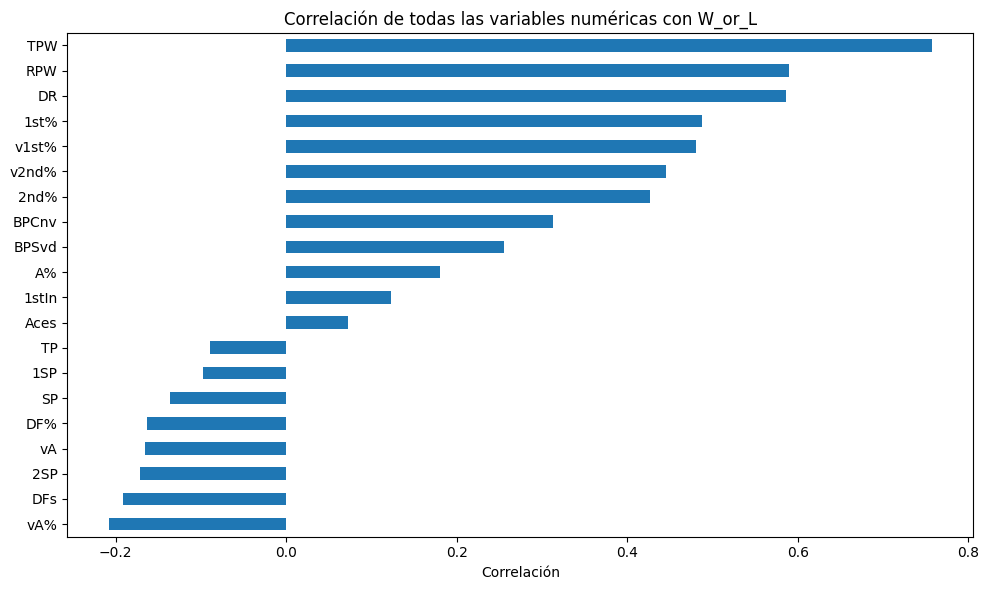

In [10]:
from sklearn.preprocessing import LabelEncoder

# Copia del DataFrame procesado
df_model = df_filtrado.copy()

# Eliminar filas sin W_or_L
df_model = df_model[df_model['W_or_L'].notna()]

# Codificar W_or_L como 1 (W) y 0 (L)
le = LabelEncoder()
df_model['W_or_L_encoded'] = le.fit_transform(df_model['W_or_L'])  # W = 1, L = 0

# Seleccionar solo columnas numéricas
df_numericas = df_model.select_dtypes(include='number')

# Calcular correlación con la variable objetivo
correlaciones_objetivo = df_numericas.corr()['W_or_L_encoded'].drop('W_or_L_encoded').sort_values(ascending=False)

# Mostrar todas las correlaciones ordenadas
print("Correlación de todas las variables numéricas con W_or_L (victoria=1, derrota=0):")
print(correlaciones_objetivo)

# Visualizar todas en gráfico de barras horizontal
plt.figure(figsize=(10, max(6, len(correlaciones_objetivo) * 0.3)))
correlaciones_objetivo.sort_values().plot(kind='barh')
plt.title('Correlación de todas las variables numéricas con W_or_L')
plt.xlabel('Correlación')
plt.tight_layout()
plt.show()


Esto nos sirve para descartar algunas variables (las menos influyentes)

In [11]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder

# Carpeta con los CSVs de cada jugador
folder = 'Tests/player_stats_con_resultado'

# Carpeta para guardar resultados
output_folder = 'Tests/correlaciones_por_jugador'
os.makedirs(output_folder, exist_ok=True)

# Columnas a excluir del análisis
columnas_excluir = ['Date', 'Tournament', 'Surface', 'Rd', 'Rk', 'vRk', 'match', 'Score']

# Función para procesar cada jugador
for filename in os.listdir(folder):
    if filename.endswith('.csv'):
        jugador = filename.replace('_matches_full_con_WorL.csv', '').replace('_con_WorL.csv', '')
        df = pd.read_csv(os.path.join(folder, filename))

        # Excluir columnas irrelevantes si existen
        df_filtrado = df.drop(columns=[col for col in columnas_excluir if col in df.columns], errors='ignore')

        # Convertir porcentajes a float
        porcentaje_cols = [col for col in df_filtrado.columns
                           if df_filtrado[col].dtype == 'object' and df_filtrado[col].astype(str).str.contains('%').any()]
        for col in porcentaje_cols:
            df_filtrado[col] = df_filtrado[col].astype(str).str.replace('%', '', regex=False)
            df_filtrado[col] = pd.to_numeric(df_filtrado[col], errors='coerce') / 100

        # Convertir fracciones a float
        def fraccion_a_float(valor):
            try:
                if isinstance(valor, str) and '/' in valor:
                    numerador, denominador = valor.split('/')
                    numerador = float(numerador)
                    denominador = float(denominador)
                    if denominador == 0:
                        return np.nan
                    return numerador / denominador
                return float(valor)
            except:
                return np.nan

        fraccion_cols = [col for col in df_filtrado.columns
                         if df_filtrado[col].astype(str).str.contains(r'^\d+/\d+$').any()]
        for col in fraccion_cols:
            df_filtrado[col] = df_filtrado[col].apply(fraccion_a_float)

        # Convertir decimales en texto
        decimal_cols = [col for col in df_filtrado.columns
                        if df_filtrado[col].dtype == 'object' and df_filtrado[col].astype(str).str.contains(r'^\d+\.\d+$').any()]
        for col in decimal_cols:
            df_filtrado[col] = pd.to_numeric(df_filtrado[col], errors='coerce')

        # Filtrar y codificar W_or_L
        df_model = df_filtrado[df_filtrado['W_or_L'].notna()].copy()
        if df_model.empty:
            print(f"{jugador}: sin datos válidos para análisis.")
            continue

        le = LabelEncoder()
        df_model['W_or_L_encoded'] = le.fit_transform(df_model['W_or_L'])  # W = 1, L = 0

        # Calcular correlaciones con W_or_L
        df_numericas = df_model.select_dtypes(include='number')
        correlaciones = df_numericas.corr()['W_or_L_encoded'].drop('W_or_L_encoded')

        # Guardar resultado
        correlaciones.to_csv(os.path.join(output_folder, f'{jugador}_correlacion_con_W_or_L.csv'))
        print(f"{jugador}: correlaciones guardadas.")


AlexanderZverev: correlaciones guardadas.
AndreyRublev: correlaciones guardadas.
CarlosAlcaraz: correlaciones guardadas.
CasperRuud: correlaciones guardadas.
DaniilMedvedev: correlaciones guardadas.
HolgerRune: correlaciones guardadas.
HubertHurkacz: correlaciones guardadas.
JannikSinner: correlaciones guardadas.
NovakDjokovic: correlaciones guardadas.
StefanosTsitsipas: correlaciones guardadas.



Correlación de variables con W_or_L para AlexanderZverev:



DF%     -0.255302
DFs     -0.243103
vA%     -0.205345
vA      -0.200934
2SP     -0.180609
SP      -0.117106
TP      -0.098583
1SP     -0.066668
Aces     0.147422
1stIn    0.166001
A%       0.285122
BPSvd    0.336409
BPCnv    0.373717
v2nd%    0.374747
2nd%     0.440102
v1st%    0.445146
1st%     0.529212
RPW      0.540157
DR       0.556594
TPW      0.761720
Name: W_or_L_encoded, dtype: float64

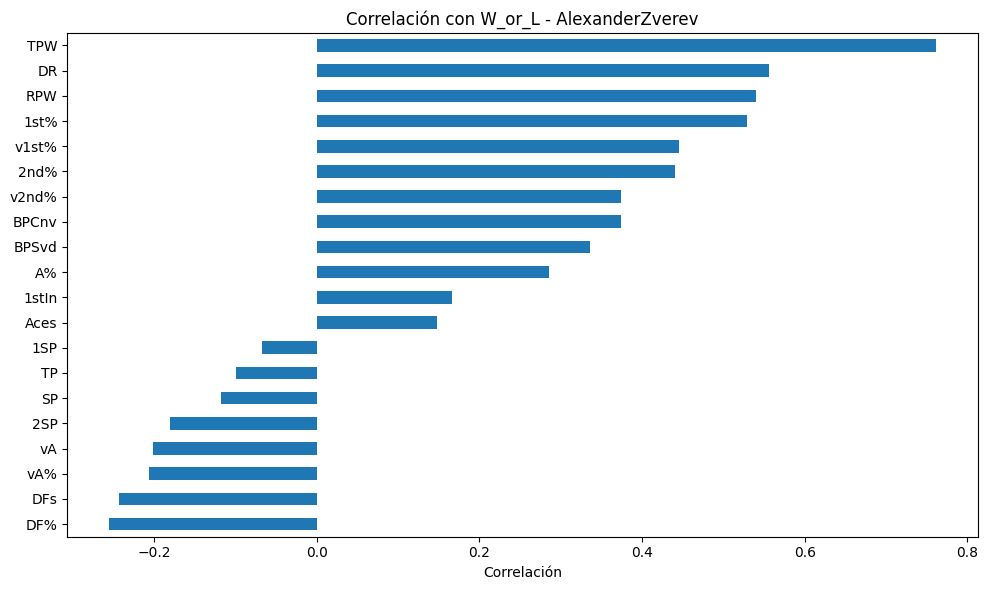


Correlación de variables con W_or_L para AndreyRublev:



DFs     -0.198679
DF%     -0.174803
vA%     -0.165054
vA      -0.137664
2SP     -0.123252
SP      -0.104250
1SP     -0.077947
TP      -0.065725
1stIn    0.082119
Aces     0.156837
A%       0.242896
BPSvd    0.292655
BPCnv    0.300870
2nd%     0.421212
v2nd%    0.422245
v1st%    0.501602
1st%     0.512317
RPW      0.620511
DR       0.676208
TPW      0.788988
Name: W_or_L_encoded, dtype: float64

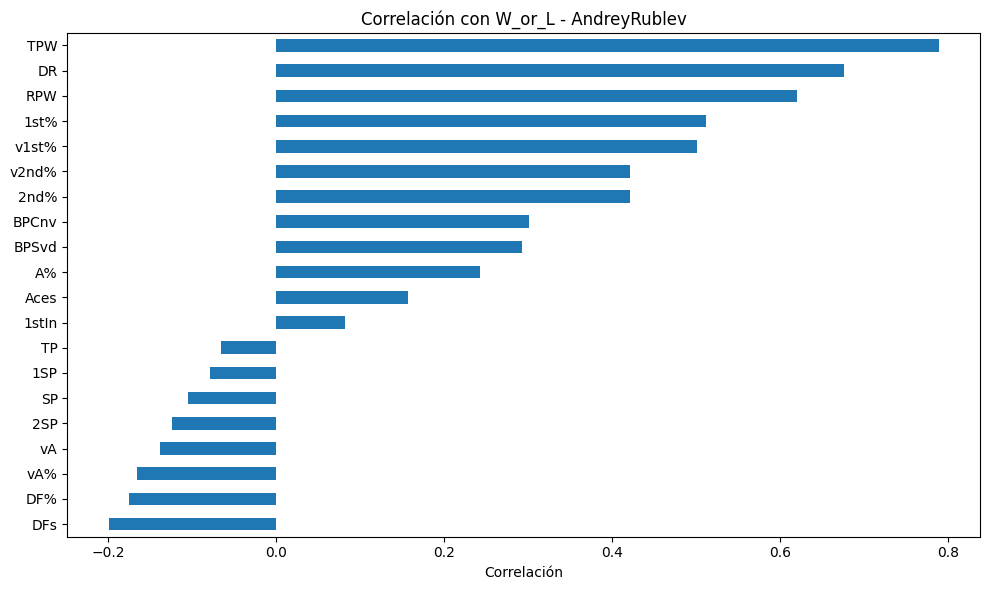


Correlación de variables con W_or_L para CarlosAlcaraz:



vA%     -0.196193
vA      -0.153737
2SP     -0.144258
SP      -0.129478
DFs     -0.129317
TP      -0.118716
1SP     -0.109247
DF%     -0.082482
Aces     0.025244
1stIn    0.082658
A%       0.104443
BPSvd    0.231066
BPCnv    0.351788
v2nd%    0.377364
2nd%     0.386407
1st%     0.410654
v1st%    0.429566
DR       0.524042
RPW      0.533625
TPW      0.720071
Name: W_or_L_encoded, dtype: float64

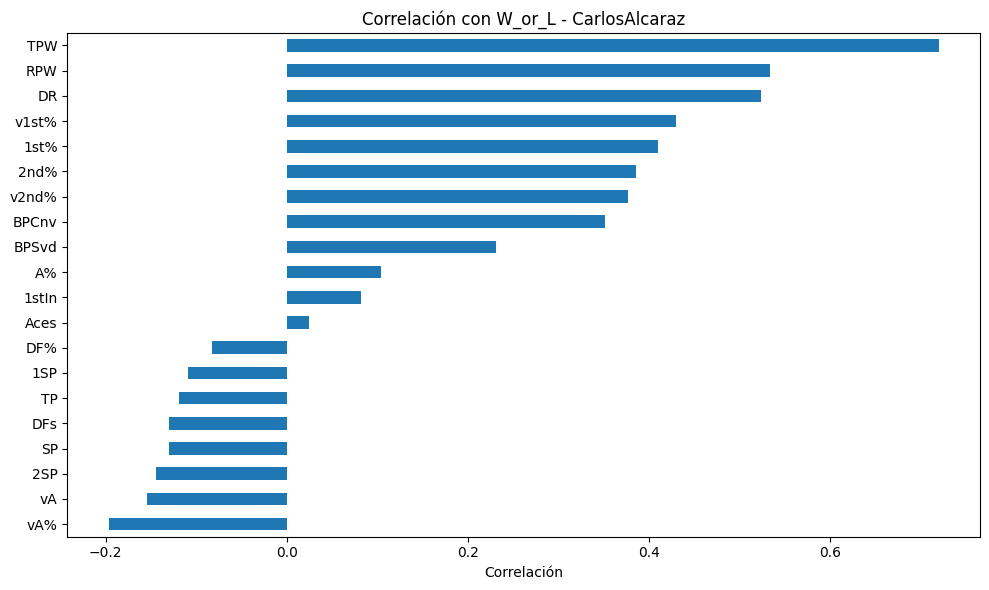


Correlación de variables con W_or_L para CasperRuud:



vA%     -0.233619
vA      -0.160321
DFs     -0.149173
2SP     -0.122689
DF%     -0.114324
SP      -0.105618
1SP     -0.084504
TP      -0.043583
1stIn    0.068884
Aces     0.110681
A%       0.206075
BPSvd    0.245351
BPCnv    0.294403
2nd%     0.469906
v2nd%    0.482286
v1st%    0.531218
1st%     0.559557
DR       0.610593
RPW      0.630281
TPW      0.786721
Name: W_or_L_encoded, dtype: float64

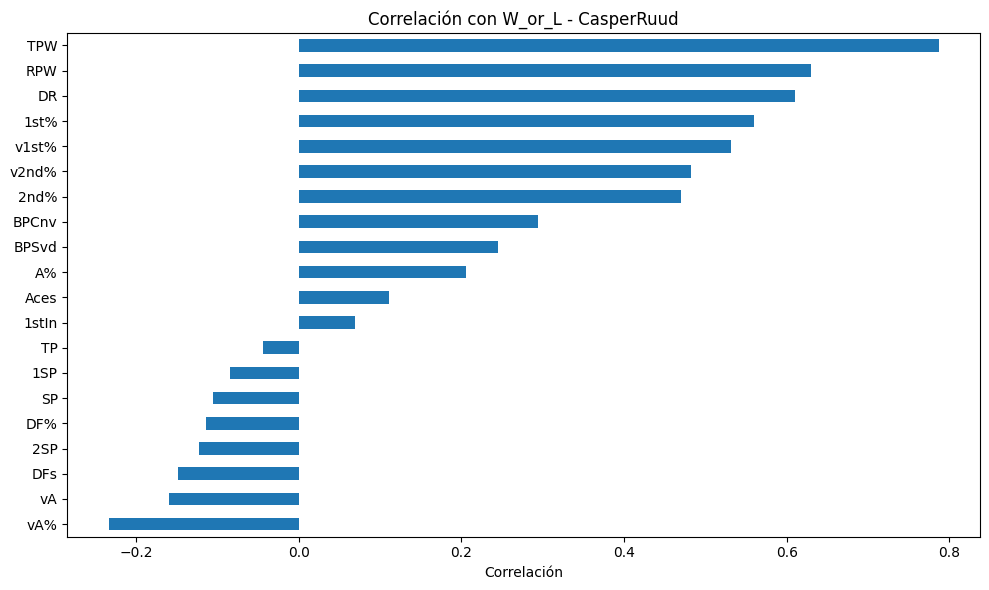


Correlación de variables con W_or_L para DaniilMedvedev:



vA%     -0.209827
2SP     -0.200831
SP      -0.161393
vA      -0.152764
DFs     -0.148053
1SP     -0.115039
TP      -0.107667
DF%     -0.096777
Aces     0.136343
1stIn    0.153953
BPSvd    0.223898
A%       0.308199
BPCnv    0.350866
2nd%     0.386833
v1st%    0.487150
v2nd%    0.493608
1st%     0.541814
RPW      0.616002
DR       0.638847
TPW      0.773640
Name: W_or_L_encoded, dtype: float64

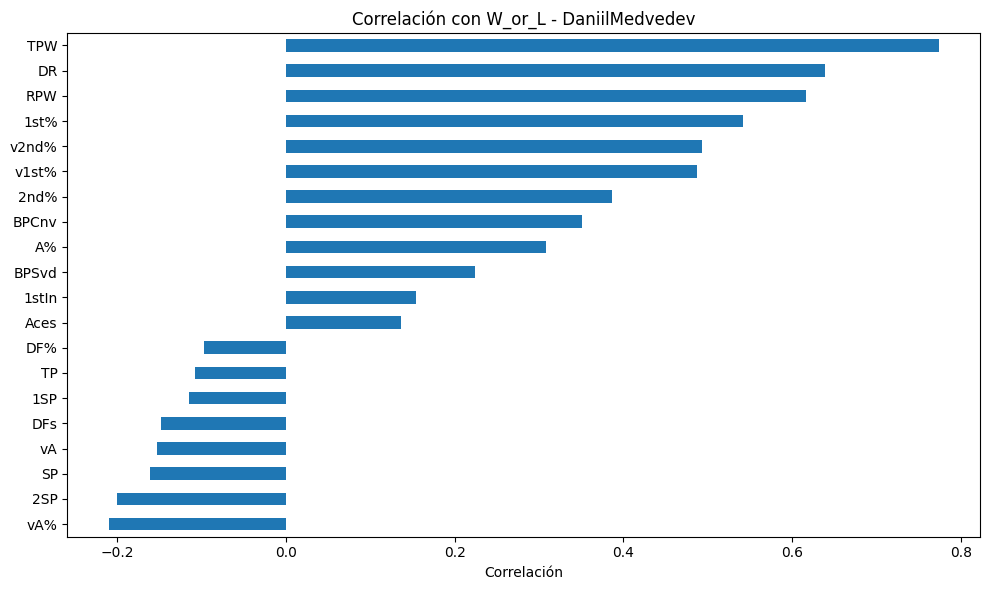


Correlación de variables con W_or_L para HolgerRune:



vA%     -0.300021
DF%     -0.245778
vA      -0.223625
DFs     -0.218913
2SP     -0.116334
SP      -0.064646
1SP     -0.020771
TP      -0.008999
1stIn    0.126485
Aces     0.146605
A%       0.237632
BPCnv    0.274561
BPSvd    0.300968
v2nd%    0.419161
v1st%    0.461751
2nd%     0.493296
1st%     0.561536
RPW      0.588962
DR       0.599728
TPW      0.758394
Name: W_or_L_encoded, dtype: float64

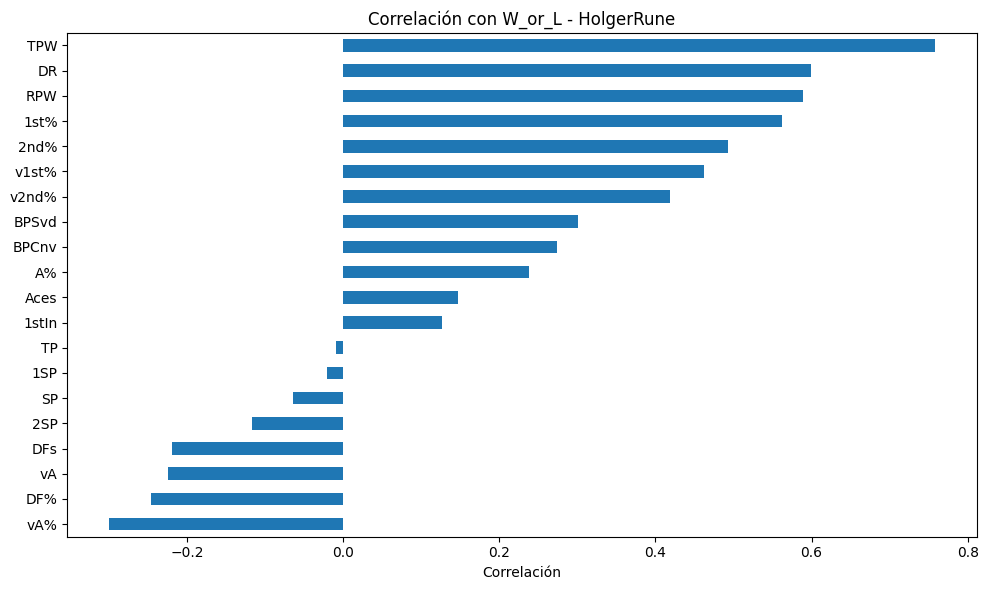


Correlación de variables con W_or_L para HubertHurkacz:



2SP     -0.229414
DFs     -0.221473
SP      -0.208152
DF%     -0.190622
vA%     -0.184172
1SP     -0.168187
vA      -0.152874
TP      -0.149062
Aces     0.110613
1stIn    0.129973
A%       0.254806
BPSvd    0.300093
BPCnv    0.309590
2nd%     0.431421
v1st%    0.443536
v2nd%    0.466742
1st%     0.486509
RPW      0.568929
DR       0.655461
TPW      0.758276
Name: W_or_L_encoded, dtype: float64

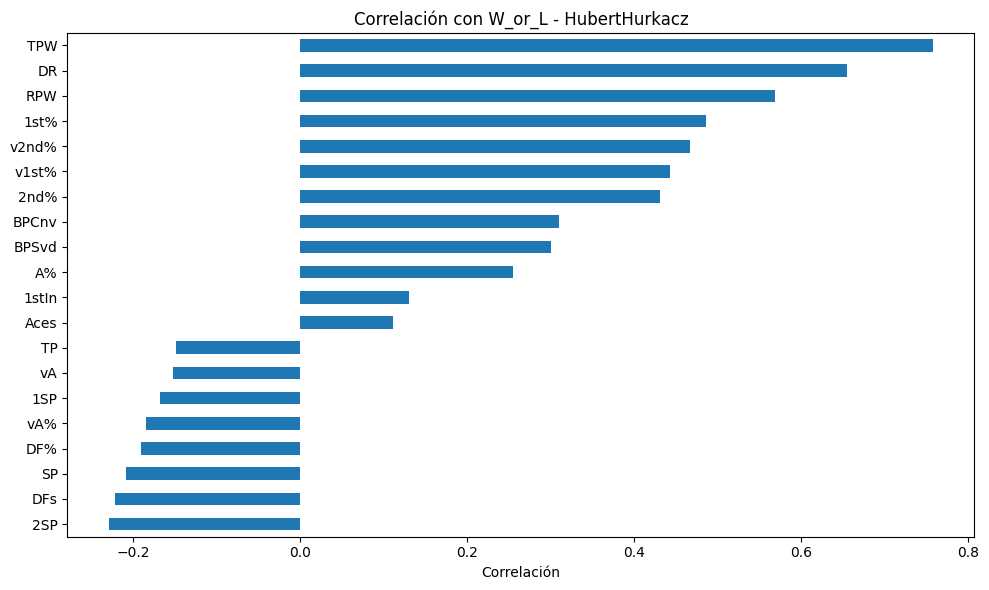


Correlación de variables con W_or_L para JannikSinner:



2SP     -0.174900
DFs     -0.170053
vA%     -0.160289
SP      -0.156186
vA      -0.142453
1SP     -0.126748
TP      -0.126122
DF%     -0.115292
1stIn    0.088447
Aces     0.175475
BPCnv    0.239467
A%       0.285004
BPSvd    0.305893
v2nd%    0.374303
v1st%    0.426363
2nd%     0.430522
RPW      0.524873
1st%     0.537655
DR       0.543833
TPW      0.746238
Name: W_or_L_encoded, dtype: float64

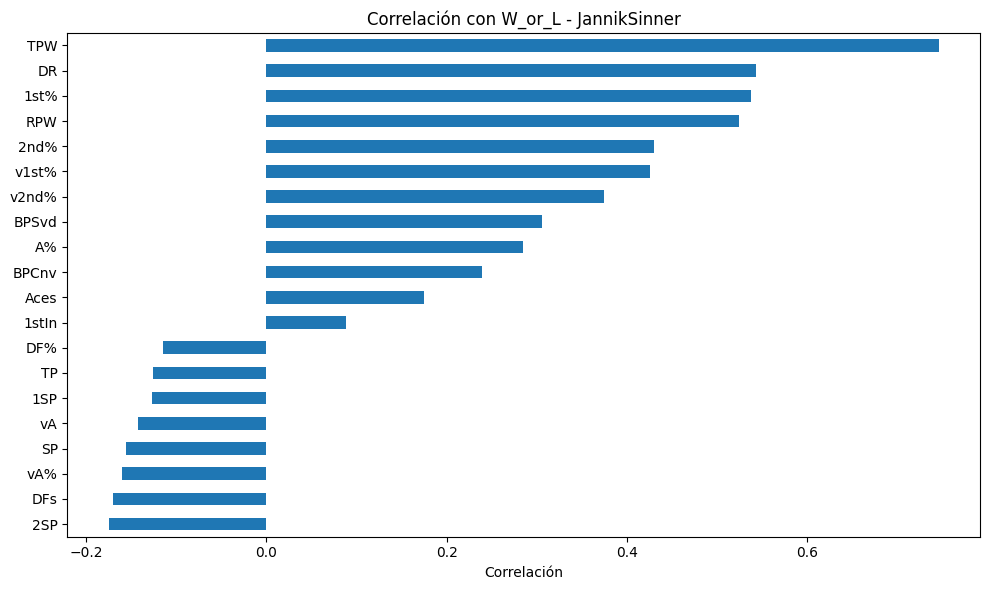


Correlación de variables con W_or_L para NovakDjokovic:



2SP     -0.170867
vA%     -0.158283
SP      -0.156373
DFs     -0.148446
1SP     -0.135711
vA      -0.132607
TP      -0.110365
DF%     -0.096886
Aces     0.083958
1stIn    0.093794
A%       0.168667
BPSvd    0.171422
BPCnv    0.244882
2nd%     0.347243
v1st%    0.412637
v2nd%    0.433062
1st%     0.457141
DR       0.480891
RPW      0.536416
TPW      0.688168
Name: W_or_L_encoded, dtype: float64

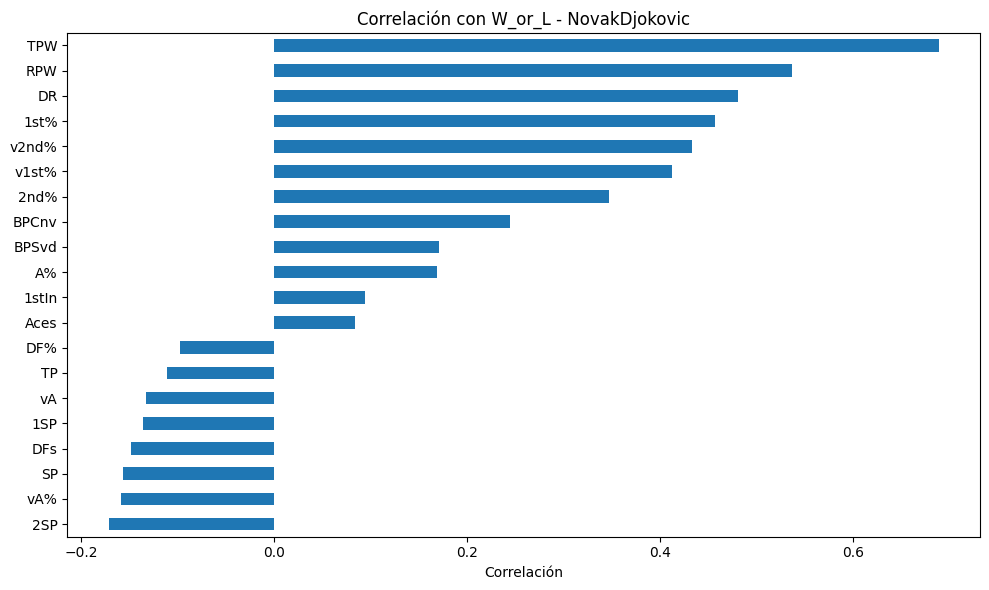


Correlación de variables con W_or_L para StefanosTsitsipas:



vA%     -0.301911
vA      -0.235434
DFs     -0.190140
2SP     -0.172859
DF%     -0.142224
SP      -0.141966
1SP     -0.106443
TP      -0.086334
Aces    -0.029236
A%       0.077051
1stIn    0.097756
BPSvd    0.243127
BPCnv    0.307607
v2nd%    0.418665
1st%     0.430210
2nd%     0.439981
v1st%    0.498975
RPW      0.596552
DR       0.612527
TPW      0.752749
Name: W_or_L_encoded, dtype: float64

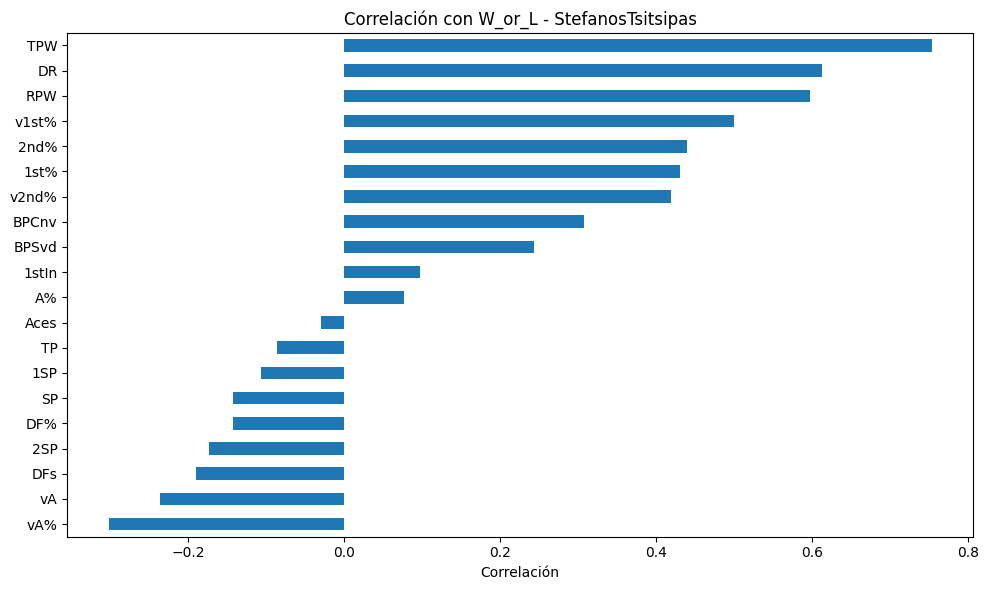

In [12]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Carpeta con los CSVs de cada jugador
folder = 'Tests/player_stats_con_resultado'

# Columnas a excluir del análisis
columnas_excluir = ['Date', 'Tournament', 'Surface', 'Rd', 'Rk', 'vRk', 'match', 'Score']

# Procesar cada jugador
for filename in os.listdir(folder):
    if filename.endswith('.csv'):
        jugador = filename.replace('_matches_full_con_WorL.csv', '').replace('_con_WorL.csv', '')
        df = pd.read_csv(os.path.join(folder, filename))

        # Excluir columnas irrelevantes si existen
        df_filtrado = df.drop(columns=[col for col in columnas_excluir if col in df.columns], errors='ignore')

        # Convertir porcentajes a float
        porcentaje_cols = [col for col in df_filtrado.columns
                           if df_filtrado[col].dtype == 'object' and df_filtrado[col].astype(str).str.contains('%').any()]
        for col in porcentaje_cols:
            df_filtrado[col] = df_filtrado[col].astype(str).str.replace('%', '', regex=False)
            df_filtrado[col] = pd.to_numeric(df_filtrado[col], errors='coerce') / 100

        # Convertir fracciones a float
        def fraccion_a_float(valor):
            try:
                if isinstance(valor, str) and '/' in valor:
                    numerador, denominador = valor.split('/')
                    numerador = float(numerador)
                    denominador = float(denominador)
                    if denominador == 0:
                        return np.nan
                    return numerador / denominador
                return float(valor)
            except:
                return np.nan

        fraccion_cols = [col for col in df_filtrado.columns
                         if df_filtrado[col].astype(str).str.contains(r'^\d+/\d+$').any()]
        for col in fraccion_cols:
            df_filtrado[col] = df_filtrado[col].apply(fraccion_a_float)

        # Convertir decimales en texto
        decimal_cols = [col for col in df_filtrado.columns
                        if df_filtrado[col].dtype == 'object' and df_filtrado[col].astype(str).str.contains(r'^\d+\.\d+$').any()]
        for col in decimal_cols:
            df_filtrado[col] = pd.to_numeric(df_filtrado[col], errors='coerce')

        # Filtrar y codificar W_or_L
        df_model = df_filtrado[df_filtrado['W_or_L'].notna()].copy()
        if df_model.empty:
            print(f"{jugador}: sin datos válidos para análisis.")
            continue

        le = LabelEncoder()
        df_model['W_or_L_encoded'] = le.fit_transform(df_model['W_or_L'])  # W = 1, L = 0

        # Calcular correlaciones con W_or_L
        df_numericas = df_model.select_dtypes(include='number')
        correlaciones = df_numericas.corr()['W_or_L_encoded'].drop('W_or_L_encoded').sort_values()

        # Mostrar resultados
        print(f"\nCorrelación de variables con W_or_L para {jugador}:\n")
        display(correlaciones)

        # Gráfico de barras
        plt.figure(figsize=(10, max(6, len(correlaciones) * 0.3)))
        correlaciones.plot(kind='barh')
        plt.title(f'Correlación con W_or_L - {jugador}')
        plt.xlabel('Correlación')
        plt.tight_layout()
        plt.show()
